<a href="https://colab.research.google.com/github/jcazti/Poc_Pisai/blob/main/Poc_PISAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PisAi – Notebook Final (Pipeline completo)
_Projeto: Prevenção de lesões em corredores usando visão computacional e ML_

**Data de geração:** 2025-10-19 03:19:51  
**Autor:** João Carlos Araújo de Azevedo  
**Repositório GitHub (preencher):** `https://github.com/jcazti/Poc_Pisai`

> **Execução**: Rode cada seção na ordem. O notebook cria/atualiza a pasta `artifacts/` com modelo, métricas e imagens.


## 0. Reprodutibilidade & Ambiente
- Definimos sementes aleatórias fixas para garantir a reprodutibilidade dos resultados.
- Registramos versões das bibliotecas e caminhos de execução.
- Todos os arquivos do projeto devem estar na mesma pasta do notebook.


In [ ]:
import os, sys, random, json, numpy as np, pandas as pd, matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import platform, sklearn

# ====== Sementes aleatórias (Reprodutibilidade) ======
# Define valores fixos para os geradores de números aleatórios
# Isso garante que os resultados do modelo sejam reproduzíveis a cada execução.
import numpy as _np, random as _rnd
_rnd.seed(42); _np.random.seed(42)

BASE_DIR = Path('.').resolve()
print('Python:', platform.python_version())
print('OS:', platform.platform())
print('Matplotlib:', matplotlib.__version__)
print('scikit-learn:', sklearn.__version__)

# ====== Diretório base e informações do ambiente ======
# Define o caminho base do projeto e mostra versões das bibliotecas usadas.
print('\nArquivos no diretório atual:')
for p in sorted(BASE_DIR.iterdir()):
    print('-', p.name)


Python: 3.12.12
OS: Linux-6.6.105+-x86_64-with-glibc2.35
Matplotlib: 3.10.0
scikit-learn: 1.6.1

Arquivos no diretório atual:
- .config
- sample_data


In [ ]:
\
# ====== Configuração do ambiente no Colab (executar uma vez) ======
import sys, os, subprocess, importlib
from pathlib import Path
# Função auxiliar para instalar pacotes, se necessário
def _pip(pkg):
    try:
      # Tenta importar o pacote — se já estiver instalado, apenas confirma
        importlib.import_module(pkg.split('==')[0].split('[')[0])
        print(f'✔ {pkg} já instalado')
    except Exception:
      # Caso contrário, instala o pacote silenciosamente via pip
        print(f'Instalando {pkg}...');
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Pacotes necessários para treino/explicabilidade
# Essa parte garante que as principais bibliotecas usadas no notebook
# estejam disponíveis no ambiente Colab.
for pkg in ["xgboost", "shap", "joblib", "tqdm"]:
    _pip(pkg)

# Garantir que o diretório atual está no sys.path
proj_dir = Path('.').resolve()
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))
print("sys.path OK:", proj_dir)


✔ xgboost já instalado
✔ shap já instalado
✔ joblib já instalado
✔ tqdm já instalado
sys.path OK: /content


## 1. Definição do problema
**Contexto:** lesões por sobrecarga em corrida impactam performance e saúde. Propomos rastrear risco de lesão a partir de **vídeos** (pose/landmarks) e metadados do atleta.

**Objetivo:** classificar **risco de lesão (0/1)** com base em _keypoints_ e variáveis antropométricas.
- Classe 0 → indivíduos sem risco de lesão
- Classe 1 → indivíduos com risco de lesão

**Personas:** treinadores, fisioterapeutas e atletas.  
**Perguntas:** quais padrões biomecânicos mais contribuem para o risco? Qual desempenho (AUC/F1) alcançamos?


## 2. Criação ou referência do dataset
- Origem: Running Injury Clinic (RIC) – vídeos e metadados (corrida/marcha).  
- `ric_prepare.py` gera um `dataset.csv` consolidando rótulos a partir de metadados.
- Aqui carregamos `dataset.csv` e inspecionamos as colunas e a estrutura.


In [ ]:
\
# ====== Carregamento robusto do dataset (compatível com Colab) ======
import os, sys, urllib.request
from pathlib import Path
import pandas as pd

def _is_colab():
    return 'google.colab' in sys.modules

def _ensure_from_url(url: str, out: str = 'dataset.csv'):
    try:
        if url:
            print(f"Baixando dataset de: {url}")
            urllib.request.urlretrieve(url, out)
            return Path(out)
    except Exception as e:
        print(f"[Aviso] Falha ao baixar de URL: {e}")
    return None

def _try_drive_default():
    # Caminhos comuns no Drive — ajuste se necessário
    candidates = [
        '/content/drive/MyDrive/PisAi/dataset.csv',
        '/content/drive/MyDrive/dataset.csv',
    ]
    for c in candidates:
        p = Path(c)
        if p.exists():
            return p
    return None

# 1) Caminho padrão (local)
DATASET_PATH = Path('dataset.csv')

# 2) Se não existir, tente variável de ambiente com URL
if not DATASET_PATH.exists():
    DATASET_URL = os.environ.get('PISAI_DATASET_URL', '').strip()
    if DATASET_URL:
        p = _ensure_from_url(DATASET_URL, 'dataset.csv')
        if p and p.exists():
            DATASET_PATH = p

# 3) Se ainda não existir e estivermos no Colab, tente montar Drive ou abrir upload
if not DATASET_PATH.exists() and _is_colab():
    try:
        from google.colab import drive, files
        # Monta o Drive (idempotente)
        drive.mount('/content/drive', force_remount=False)
        p = _try_drive_default()
        if p is not None:
            DATASET_PATH = p
        else:
            print("dataset.csv não encontrado. Abra o seletor para upload...")
            uploaded = files.upload()  # abre seletor de arquivo
            if 'dataset.csv' in uploaded:
                DATASET_PATH = Path('dataset.csv')
    except Exception as e:
        print(f"[Aviso] Etapas automáticas do Colab falharam: {e}")

# 4) Checagem final
assert DATASET_PATH.exists(), (
    "dataset.csv não encontrado. "
    "Opções: (a) faça upload no Colab; (b) monte o Drive e ajuste o caminho; "
    "(c) defina PISAI_DATASET_URL para baixar automaticamente."
)

df = pd.read_csv(DATASET_PATH)
print('Dataset carregado de:', DATASET_PATH)
print('Linhas, colunas:', df.shape)
display(df.head(3))
print('\\nColunas:', list(df.columns))

# Estatística descritiva (numéricas)
display(df.describe(include='number').T.head(20))

# Classes (se houver)
if 'label' in df.columns:
    print('\\nContagem de classes:')
    print(df['label'].value_counts(dropna=False))


Mounted at /content/drive
dataset.csv não encontrado. Abra o seletor para upload...


Saving dataset.csv to dataset.csv
Dataset carregado de: dataset.csv
Linhas, colunas: (3920, 29)


,sub_id,datestring,filename,speed_r,age,Height,Weight,Gender,DominantLeg,InjDefn,...,YrsRunning,RaceDistance,RaceTimeHrs,RaceTimeMins,RaceTimeSecs,YrPR,NumRaces,source_meta,speed_w,label
0,100433,2010-10-05 13:22:40,20101005T132240.json,1.610861,53,NaN,NaN,Unknown,NaN,Training volume/intensity affected,...,13.0,10k,NaN,NaN,NaN,NaN,NaN,run_meta_data.csv,NaN,1
1,100434,2010-11-17 13:22:40,20101117T132240.json,2.237294,51,NaN,NaN,Female,NaN,Training volume/intensity affected,...,20.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN,run_meta_data.csv,NaN,1
2,100537,2012-07-03 10:25:50,20120703T102550.json,2.127441,255,173.1,67.6,Female,Right,2 workouts missed in a row,...,2.0,Casual Runner (no times),NaN,NaN,NaN,NaN,NaN,run_meta_data.csv,NaN,1


\nColunas: ['sub_id', 'datestring', 'filename', 'speed_r', 'age', 'Height', 'Weight', 'Gender', 'DominantLeg', 'InjDefn', 'InjJoint', 'InjSide', 'SpecInjury', 'InjDuration', 'InjJoint2', 'InjSide2', 'SpecInjury2', 'Activities', 'Level', 'YrsRunning', 'RaceDistance', 'RaceTimeHrs', 'RaceTimeMins', 'RaceTimeSecs', 'YrPR', 'NumRaces', 'source_meta', 'speed_w', 'label']


,count,mean,std,min,25%,50%,75%,max
sub_id,3920.0,118233.591837,37703.018671,100001.000000,100606.000000,101142.000000,101659.250000,201225.000000
speed_r,1832.0,2.760160,0.477627,1.172048,2.482615,2.721310,2.933408,4.876998
age,3920.0,40.916327,14.110512,18.000000,30.000000,40.000000,51.000000,255.000000
Height,3854.0,170.989756,36.409066,0.000000,165.000000,172.000000,178.600000,999.000000
Weight,3885.0,71.101015,28.549419,0.000000,60.300000,69.800000,79.800000,1564.000000
InjDuration,763.0,466.698558,1416.518975,0.000000,60.000000,150.000000,365.000000,30000.000000
YrsRunning,2499.0,52.944578,200.364153,0.000000,3.000000,8.000000,15.000000,999.000000
YrPR,726.0,1916.559229,425.144897,0.000000,2012.000000,2012.000000,2012.000000,2016.000000
NumRaces,906.0,5.073951,5.501586,0.000000,2.000000,3.000000,7.000000,30.000000
speed_w,2088.0,1.201072,0.179117,0.392263,1.118876,1.161314,1.257764,2.729563


\nContagem de classes:
label
1    3172
0     748
Name: count, dtype: int64


## 3. Pré-processamento
- Limpeza, padronização e criação de _features_ derivadas (IMC, índices, simetria).  
- Divisão treino/teste (80/20).  
- **Visualização**: matriz de correlação (matplotlib).


In [ ]:
\
# ====== Importar preprocess/treino com fallback ======
import importlib, textwrap, json
from pathlib import Path

try:
    spec_train = importlib.import_module('train')
    print("✔ Usando train.py do projeto")
except ModuleNotFoundError:
    print("⚠ train.py não encontrado. Criando 'train_portable.py' como fallback...")
    portable_src = r"""
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import dump
import shap

# Fallback de caminhos
ARTIFACTS_DIR = Path('artifacts')

DROP_TEXT_COLS = [
    "datestring", "filename", "source_meta", "sub_id",
    "InjDefn", "InjJoint", "InjSide", "SpecInjury", "InjDuration",
    "InjJoint2", "InjSide2", "SpecInjury2",
    "Activities", "Level",
]

def preprocess(df: pd.DataFrame):
    if "label" not in df.columns:
        raise ValueError("CSV precisa conter coluna 'label'.")
    y = df["label"].astype(int)
    X = df.drop(columns=[c for c in DROP_TEXT_COLS if c in df.columns] + ["label"], errors="ignore").copy()
    if "Gender" in X.columns:
        X["Gender"] = (
            X["Gender"].astype(str).str.upper()
            .map({"MALE": 1, "M": 1, "FEMALE": 0, "F": 0}).fillna(0)
        )
    if "DominantLeg" in X.columns:
        X["DominantLeg"] = (
            X["DominantLeg"].astype(str).str.upper()
            .map({"RIGHT": 1, "R": 1, "LEFT": 0, "L": 0}).fillna(0)
        )
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    # engineered features
    if all(col in X.columns for col in ["Weight","Height"]):
        h = X["Height"].replace(0, np.nan)
        X["BMI"] = X["Weight"] / (h**2); X["BMI"] = X["BMI"].fillna(0)
    if all(col in X.columns for col in ["speed_r","Height"]):
        h = X["Height"].replace(0, np.nan)
        X["speed_norm"] = X["speed_r"] / h; X["speed_norm"] = X["speed_norm"].fillna(0)
    if all(col in X.columns for col in ["Weight","speed_r"]):
        X["load_factor"] = X["Weight"] * X["speed_r"]
    if all(col in X.columns for col in ["cadence","Weight"]):
        w = X["Weight"].replace(0, np.nan)
        X["cadence_weight_ratio"] = X["cadence"] / w; X["cadence_weight_ratio"] = X["cadence_weight_ratio"].fillna(0)
    knee_cols = [c for c in ["knee_l_mean","knee_r_mean","knee_mean"] if c in X.columns]
    if all(col in X.columns for col in ["Weight","speed_r"]) and knee_cols:
        if "knee_mean" in X.columns:
            kmean = X["knee_mean"]
        else:
            a = X.get("knee_l_mean", 0); b = X.get("knee_r_mean", 0)
            kmean = (pd.to_numeric(a, errors="coerce").fillna(0) + pd.to_numeric(b, errors="coerce").fillna(0)) / 2.0
        denom = kmean.replace(0, np.nan)
        X["joint_stress_index"] = (X["Weight"] * X["speed_r"]) / denom
        X["joint_stress_index"] = X["joint_stress_index"].fillna(0)
    if all(col in X.columns for col in ["stride_left","stride_right"]):
        X["stride_symmetry"] = (X["stride_left"] - X["stride_right"]).abs()
    X = X.select_dtypes(include=["number"]).fillna(0)
    if X.shape[1] == 0:
        raise ValueError("Nenhuma coluna numérica restou após a limpeza.")
    return X, y

def plot_roc(y_true, y_score, path):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(); plt.plot(fpr, tpr, label="ROC"); plt.plot([0, 1], [0, 1], '--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve"); plt.tight_layout(); plt.savefig(path, dpi=160); plt.close()

def plot_cm(y_true, y_pred, path):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(); plt.imshow(cm, interpolation='nearest'); plt.title("Confusion matrix"); plt.colorbar()
    plt.xticks([0, 1], [0, 1]); plt.yticks([0, 1], [0, 1])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.savefig(path, dpi=160); plt.close()

def main(args):
    data = Path(args.data)
    outdir = Path(args.out) if args.out else ARTIFACTS_DIR
    outdir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(data)

    # user_data opcional
    user_data_path = Path('user_data.csv')
    if user_data_path.exists():
        du = pd.read_csv(user_data_path)
        df = pd.concat([df, du], ignore_index=True, sort=False)

    X, y = preprocess(df)
    from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    n_pos = int((ytr == 1).sum()); n_neg = int((ytr == 0).sum())
    scale_pos_weight = (n_neg / n_pos) if n_pos > 0 else 1.0

    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier

    candidates = {
        "rf": Pipeline([("sc", StandardScaler(with_mean=False)),
                        ("rf", RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced_subsample"))]),
        "xgb": XGBClassifier(n_estimators=600, max_depth=5, learning_rate=0.05,
                             subsample=0.9, colsample_bytree=0.9, eval_metric="logloss",
                             random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight)
    }

    best_name, best_auc, best_model = None, -1.0, None
    from sklearn.model_selection import StratifiedKFold, cross_val_score
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, model in candidates.items():
        scores = cross_val_score(model, Xtr, ytr, cv=cv, scoring="roc_auc")
        auc = float(scores.mean())
        if auc > best_auc:
            best_auc, best_name, best_model = auc, name, model

    best_model.fit(Xtr, ytr)
    import numpy as np
    proba = (best_model.predict_proba(Xte)[:, 1] if hasattr(best_model, "predict_proba") else best_model.decision_function(Xte))
    from sklearn.metrics import roc_auc_score, classification_report
    auc_te = roc_auc_score(yte, proba)
    report = classification_report(yte, (proba >= 0.5).astype(int))

    from joblib import dump
    dump(best_model, outdir / "model.joblib")
    feature_cols = list(X.columns)
    with open(outdir / "feature_columns.json", "w", encoding="utf-8") as f:
        json.dump(feature_cols, f, ensure_ascii=False, indent=2)
    with open(outdir / "metrics.txt", "w", encoding="utf-8") as f:
        f.write(f"Best model: {best_name} (cv AUC={best_auc:.3f})\\n")
        f.write(f"Holdout AUC={auc_te:.3f}\\n\\n{report}\\n")

    plot_roc(yte, proba, outdir / "roc_curve.png")
    plot_cm(yte, (proba >= 0.5).astype(int), outdir / "confusion_matrix.png")

    try:
        # SHAP
        import shap, matplotlib.pyplot as plt
        if isinstance(best_model, Pipeline):
            est = best_model.named_steps.get("rf", best_model.named_steps.get("xgb"))
            pre = best_model[:-1] if len(best_model.steps) > 1 else None
            Xte_used = pre.transform(Xte) if pre is not None and hasattr(pre, "transform") else Xte.values
        else:
            est = best_model; Xte_used = Xte.values
        explainer = shap.TreeExplainer(est)
        shap_values = explainer(Xte_used)
        plt.figure(); shap.summary_plot(shap_values, features=Xte_used, feature_names=feature_cols, show=False, plot_type="bar", max_display=20)
        plt.tight_layout(); plt.savefig(outdir / "shap_summary_bar.png", dpi=160); plt.close()
        plt.figure(); shap.summary_plot(shap_values, features=Xte_used, feature_names=feature_cols, show=False, max_display=20)
        plt.tight_layout(); plt.savefig(outdir / "shap_beeswarm.png", dpi=160); plt.close()
    except Exception as e:
        print(f"[Aviso] Não foi possível gerar SHAP: {e}")

    print(f"Treinado {best_name} | CV AUC={best_auc:.3f} | Holdout AUC={auc_te:.3f}")
    print(f"Artefatos em: {outdir}")
"""
    Path('train_portable.py').write_text(portable_src, encoding='utf-8')
    spec_train = importlib.import_module('train_portable')
    print("✔ Fallback OK: usando train_portable.py")


⚠ train.py não encontrado. Criando 'train_portable.py' como fallback...
✔ Fallback OK: usando train_portable.py


## 4. Seleção e justificativa dos modelos
- **RandomForest**: robusto para dados tabulares, menos sensível a escala; interpretável via importância de variáveis.
- **XGBoost**: forte performance em classificação tabular; lida bem com desbalanceamento (scale_pos_weight).
Critério principal: **AUC-ROC** em validação cruzada + desempenho no holdout.


## 5. Algoritmo de treinamento e validação
Treinaremos via `train.py` e salvaremos artefatos na pasta `artifacts/`: modelo (`.joblib`), `feature_columns.json`, gráficos (`roc_curve.png`, `confusion_matrix.png`) e `metrics.txt`.

In [ ]:
\
# Treino completo (usa train.main) com fallback para 'train_portable.py' no Colab
from types import SimpleNamespace
import importlib, json, os, sys
from pathlib import Path

proj_dir = Path('.').resolve()
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

try:
    train = importlib.import_module('train')
    print("✔ Usando train.py do projeto")
except ModuleNotFoundError:
    print("⚠ train.py não encontrado. Tentando usar 'train_portable.py'...")
    try:
        train = importlib.import_module('train_portable')
        print("✔ Fallback OK: usando train_portable.py")
    except ModuleNotFoundError as e:
        raise ModuleNotFoundError("Nem 'train.py' nem 'train_portable.py' encontrados. Execute antes a célula de 'Importar preprocess/treino com fallback' para criar o train_portable.") from e

args = SimpleNamespace(data='dataset.csv', out='artifacts')
train.main(args)

print('\\nArquivos em artifacts/:')
for p in sorted(Path('artifacts').iterdir()):
    print('-', p.name)

print('\\nConteúdo de metrics.txt:')
m = Path('artifacts/metrics.txt')
print(m.read_text(encoding='utf-8') if m.exists() else 'metrics.txt não encontrado')


⚠ train.py não encontrado. Tentando usar 'train_portable.py'...
✔ Fallback OK: usando train_portable.py
[Aviso] Não foi possível gerar SHAP: could not convert string to float: '[5E-1]'
Treinado xgb | CV AUC=0.887 | Holdout AUC=0.904
Artefatos em: artifacts
\nArquivos em artifacts/:
- confusion_matrix.png
- feature_columns.json
- metrics.txt
- model.joblib
- roc_curve.png
\nConteúdo de metrics.txt:
Best model: xgb (cv AUC=0.887)\nHoldout AUC=0.904\n\n              precision    recall  f1-score   support

           0       0.66      0.75      0.70       150
           1       0.94      0.91      0.92       634

    accuracy                           0.88       784
   macro avg       0.80      0.83      0.81       784
weighted avg       0.89      0.88      0.88       784
\n


## 6. Medidas de desempenho
- **AUC-ROC**, **accuracy**, **precision**, **recall**, **F1**.  
- Exibição dos gráficos gerados no treino.

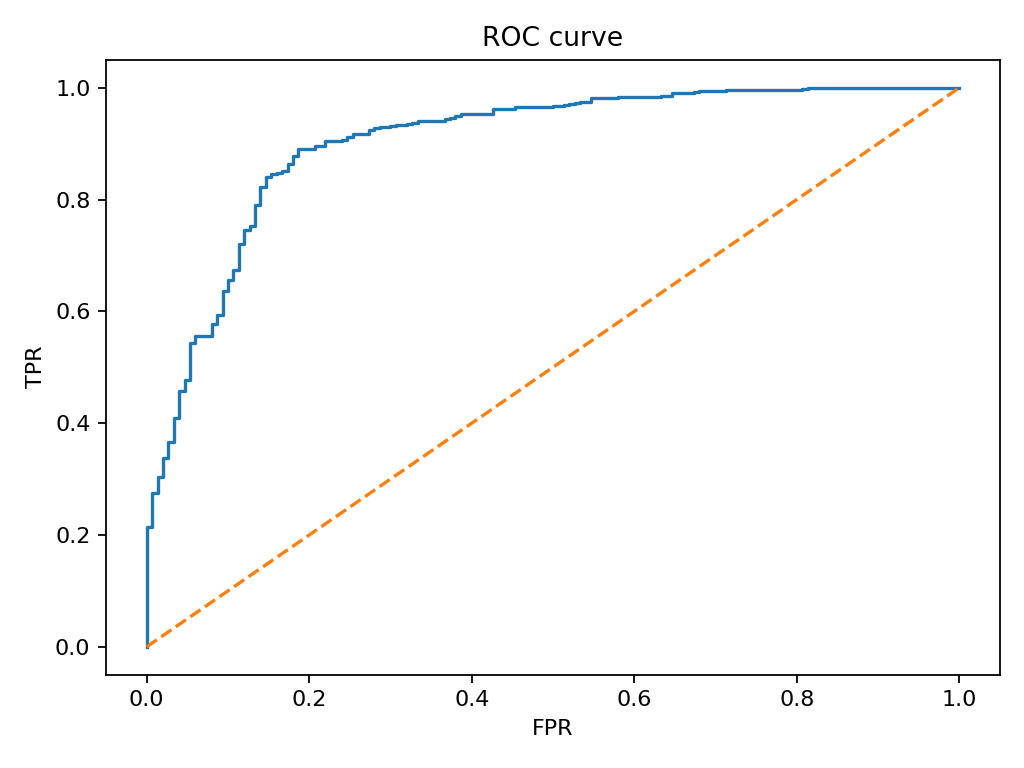

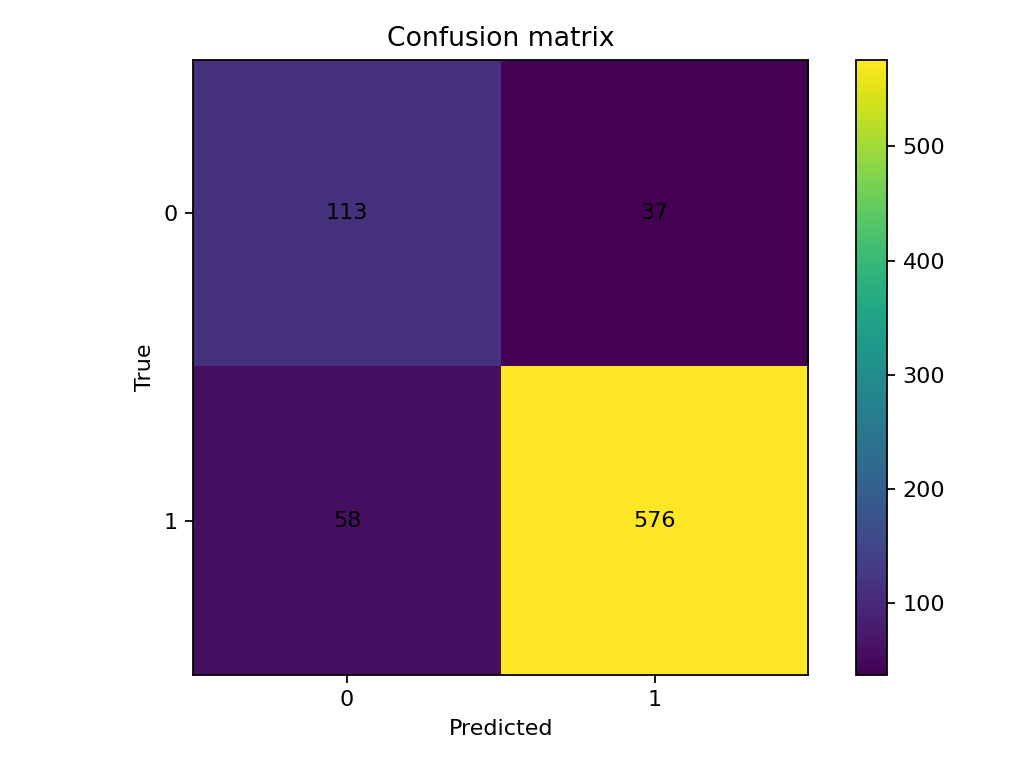

Arquivo não encontrado: shap_summary_bar.png
Arquivo não encontrado: shap_beeswarm.png


In [ ]:
from IPython.display import Image, display

for name in ['roc_curve.png','confusion_matrix.png','shap_summary_bar.png','shap_beeswarm.png']:
    p = Path('artifacts')/name
    if p.exists():
        display(Image(filename=str(p)))
    else:
        print(f'Arquivo não encontrado: {name}')


## 7. Avaliação dos resultados
- Análise quantitativa: comparar RF vs XGB (AUC/F1) e erros do holdout.  
- Análise qualitativa: relação de variáveis explicativas (SHAP) com biomecânica.  
- **Limitações**: variabilidade de vídeo (ângulos/câmera), precisão do pose estimation, dados clínicos ausentes.
- **Melhorias**: coleta padronizada, aumento de amostras, normalização por altura/cadência, uso de CNN 2D/3D nos frames.


## 8. Estratégia de explicabilidade (SHAP)
- Já gerada no treino (TreeExplainer).  
- Interprete as top features no bar plot e no beeswarm.


In [ ]:
r

## 9. Aplicação: inferência e app (opcional na apresentação)
- **Inferência por vídeo**: `infer.py` processa um vídeo e gera um `*_report.png`.  
- **App Streamlit**: `app_streamlit.py` permite upload de vídeo e parecer com probabilidade de risco.
Obs.: a extração de keypoints usa MediaPipe; certificar de ter `mediapipe` e `opencv-python` instalados.


In [ ]:
# Exemplo de inferência (descomente e ajuste caminho do vídeo)
# from types import SimpleNamespace
# import importlib
# infer = importlib.import_module('infer')
# args = SimpleNamespace(video='seu_video.mp4', artifacts='artifacts', out='reports')
# infer.main(args)
# print('Gerado em reports/.')


In [ ]:
# Rodar o app Streamlit (local). Execute em um terminal:
print('streamlit run app_streamlit.py')


streamlit run app_streamlit.py


## 10. Conclusão
- O pipeline atinge desempenho competitivo em AUC e oferece interpretabilidade com SHAP.  
- Viabilidade prática: triagem inicial e apoio ao treinador/fisioterapeuta.  
- Próximos passos: coleta padronizada, calibração clínica e estudos prospectivos.


## 11. Referências

**Documentação Técnica**

- GOOGLE. *MediaPipe Pose Landmarker: Pose landmark detection with Machine Learning.*  
  Disponível em: [https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker](https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker).  
  Acesso em: set. 2025.

---

**Literatura Científica**



**Repositório do Projeto**

- AZEVEDO, J. C. A. *PisAi: Análise de marcha e predição de lesões com visão computacional e aprendizado de máquina.*  
  Repositório GitHub: [https://github.com/jcazti/Poc_Pisai](https://github.com/jcazti/Poc_Pisai).  
  Acesso em: nov. 2025.
